In [33]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
from eofs.standard import Eof
import netCDF4
import calendar
from sklearn.linear_model import LinearRegression

In [71]:
def flatten_data(x, y):
    lr = LinearRegression().fit(x, y)
    slope = lr.coef_[0][0]
    y_int = lr.intercept_[0]
    flattened = np.zeros(shape=(sst.shape[0]))
    for ind in range(len(x)):
        expected_val = slope * x[ind] + y_int
        flattened[ind]=y[ind] - expected_val
    return flattened

def climatology(sst):
    #定义一个存储12个月气候态平均和趋势的数组
    sstmc=sst[0:12,:,:]
    for i in np.arange(12):
        ssti =  sst[(12*years+i),:,:]
        sstmc[i,:,:] = ssti.mean(dim='time')[:,:]
    return sstmc


导入数据

In [35]:
dataset = netCDF4.Dataset('sst.mnmean.nc')
s = xr.open_dataset(xr.backends.NetCDF4DataStore(dataset)) 

In [272]:
lati = np.where((s['lat']>-30-1)&(s['lat']<30+1))
loni = np.where((s['lon']>135-1)&(s['lon']<280+1))

筛选出兴趣区域，此处为时间1980以后，太平洋区域

In [273]:
sst = s['sst'][1512:-3,np.min(lati):np.max(lati),np.min(loni):np.max(loni)]

showt = datetime.datetime(1980,1,1)
sst.sel(time=np.datetime64(showt))

计算气候态，anomaly

In [174]:
year = int(np.floor(sst.shape[0]/12))
years = np.arange(year)
ssta_dc = sst.copy()

In [175]:
sst_c = climatology(sst)
for i in np.arange(12):
    ssta_dc[(12*years+i),:,:] = sst[(12*years+i),:,:]-climatology(sst)[i,:,:]

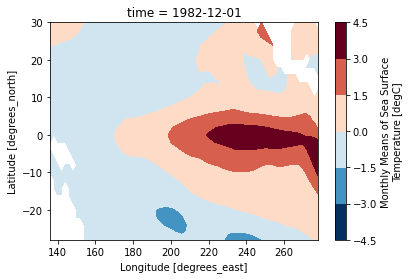

In [176]:
showt = datetime.datetime(1982,12,1)
ssta_dc.sel(time=showt).plot.contourf()

计算趋势

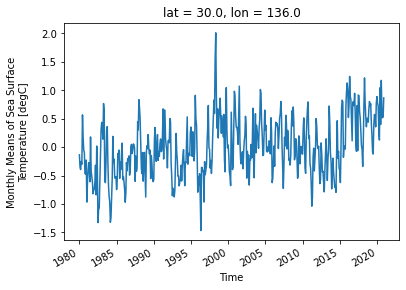

In [177]:
ssta_dc[:,0,0].plot()

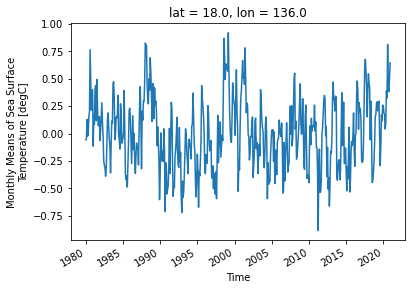

In [178]:
ssta[:,0,0].plot()

In [243]:
#去趋势
ssta = ssta_dc.copy()

for j in np.arange(sst.shape[1]):
    for k in np.arange(sst.shape[2]):
        x = np.arange(sst.shape[0]).reshape(-1, 1)
        y = np.array(ssta_dc[:,j,k]).reshape(-1, 1)
        try:
            ssta[:,j,k] = flatten_data(x, y)
        except ValueError:
            continue

计算

Time vs. Longitude (Hovmueller)

In [280]:
lati = np.where((sst['lat']>-2-1)&(sst['lat']<2+1))
latii = np.where((ssta['lat']>-2-1)&(ssta['lat']<2+1))

sstat = ssta[:,np.min(latii)-1:np.max(latii)+1,:].copy().mean(dim='lat')
sstt = sst[:,np.min(lati)-1:np.max(lati)+1,:].copy().mean(dim='lat')

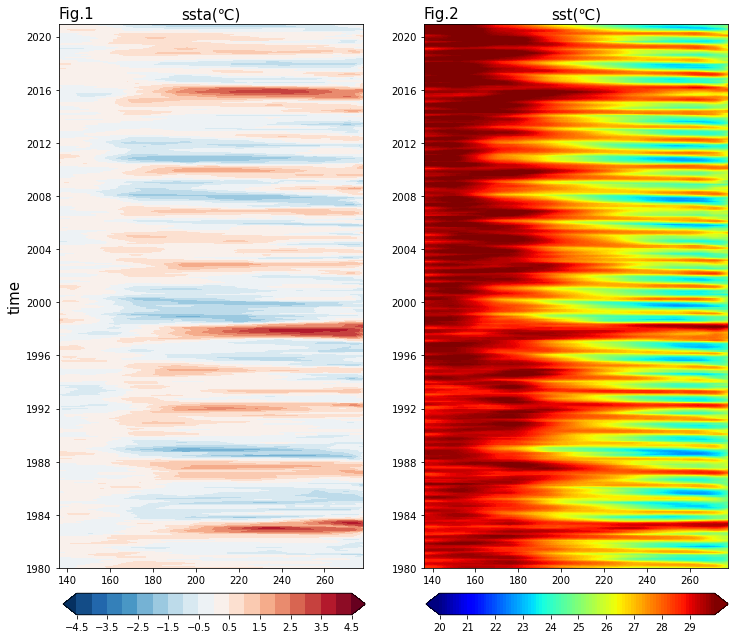

In [319]:
## ssta
fig,ax = plt.subplots(1,2,figsize=[12,10])

cbar_kwargs = {
   'orientation': 'horizontal',
   'label': '',
#    'shrink': 0.84,
    'ticks': np.arange(-5+0.5,5,1)    
}

position=fig.add_axes([0.13, 0.06, 0.35, 0.03])#位置[左,下,右,上]

levels = np.arange(-5+0.5,5,0.5)   
sstat.plot.contourf(ax=ax[0],cbar_kwargs=cbar_kwargs,levels=levels,extend='both',cbar_ax=position)
ax[0].set_title('ssta(℃)',fontsize=15)
ax[0].set_title('Fig.1',fontsize=15,loc='left')

ax[0].set_ylabel('time',fontsize=15)
ax[0].set_xlabel('')


## sst
cbar_kwargs = {
   'orientation': 'horizontal',
   'label': '',
#    'shrink': 0.84,
    'ticks': np.arange(20,30+1,1),    
}
levels=np.arange(20,30,0.1)
sstt.plot.contourf(ax=ax[1],cbar_kwargs=cbar_kwargs,cmap=plt.cm.jet,levels=levels,extend='both',cbar_ax=fig.add_axes([0.55, 0.06, 0.35, 0.03]))
ax[1].set_title('sst(℃)',fontsize=15)
# ax[1].set_ylabel('time',fontsize=15)
ax[1].set_ylabel('')
ax[1].set_xlabel('')

ax[1].set_title('Fig.2',fontsize=15,loc='left')

plt.savefig('Fig1 and 2.jpg',dpi=300,bbox_inches = 'tight')

fig3 and 4

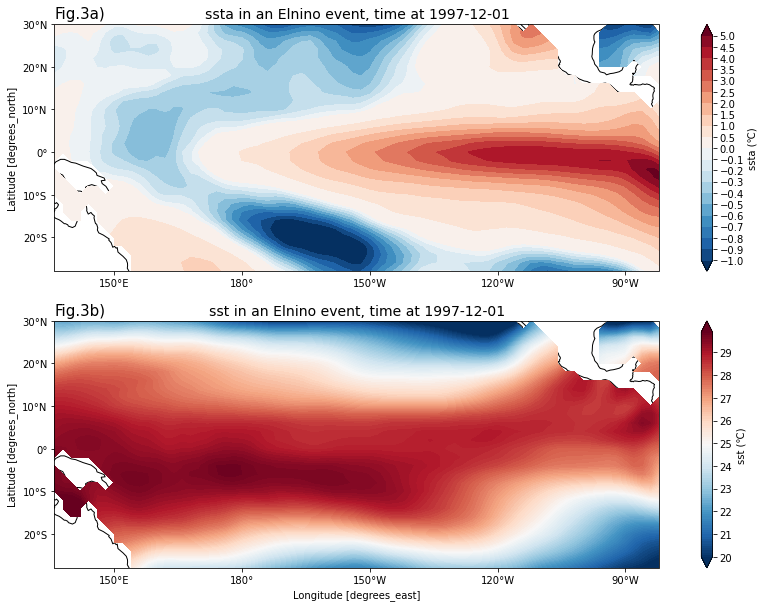

In [375]:
showt = datetime.datetime(1997,12,1)
##拼接level
fig=plt.figure(figsize=[15,10])

ax= fig.add_subplot(2,1,1,projection=ccrs.PlateCarree(central_longitude=180))

# clevs = np.arange(-1,4,0.5)
proj = ccrs.PlateCarree(central_longitude=180)

leftlon, rightlon, lowerlat, upperlat = (0,360,-90,90)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
ax.set_xticks(np.arange(leftlon,rightlon+30,30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
lev1,lev2 = np.arange(-1,0,0.1),np.arange(0,5+0.5,0.5)
clevs=np.append(lev1,lev2)
cbar_kwargs = {
   'orientation': 'vertical',
   'label': 'ssta (℃)',
   'shrink': 1,
    'ticks': clevs   
}
ssta.sel(time=showt).plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,extend='both',
                             cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree())#,cbar_ax=fig.add_axes([0.13, 0.06, 0.35, 0.03]))
ax.set_title('ssta in an Elnino event, time at '+str(showt)[:10],fontsize=14)
ax.set_title('Fig.3a)',loc='left',fontsize=15)
ax.set_xlabel('')
i=1
ax = fig.add_subplot(212,projection=ccrs.PlateCarree(central_longitude=180))

# clevs = np.arange(-1,4,0.5)
proj = ccrs.PlateCarree(central_longitude=180)

leftlon, rightlon, lowerlat, upperlat = (0,360,-90,90)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
ax.set_xticks(np.arange(leftlon,rightlon+30,30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
lev1,lev2 = np.arange(-1,0,0.1),np.arange(0,5+0.5,0.5)
clevs=np.arange(20,30,0.1)
cbar_kwargs = {
   'orientation': 'vertical',
   'label': 'sst (℃)',
   'shrink': 1,
    'ticks': np.arange(20,30+1,1) 
}

sst.sel(time=showt).plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,extend='both',
                             cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree())#,cbar_ax=fig.add_axes([0.55, 0.06, 0.35, 0.03]))
ax.set_title('sst in an Elnino event, time at '+str(showt)[:10],fontsize=14)
ax.set_title('Fig.3b)',loc='left',fontsize=15)

plt.savefig('fig3.jpg',bbox_inches = 'tight',dpi=300)

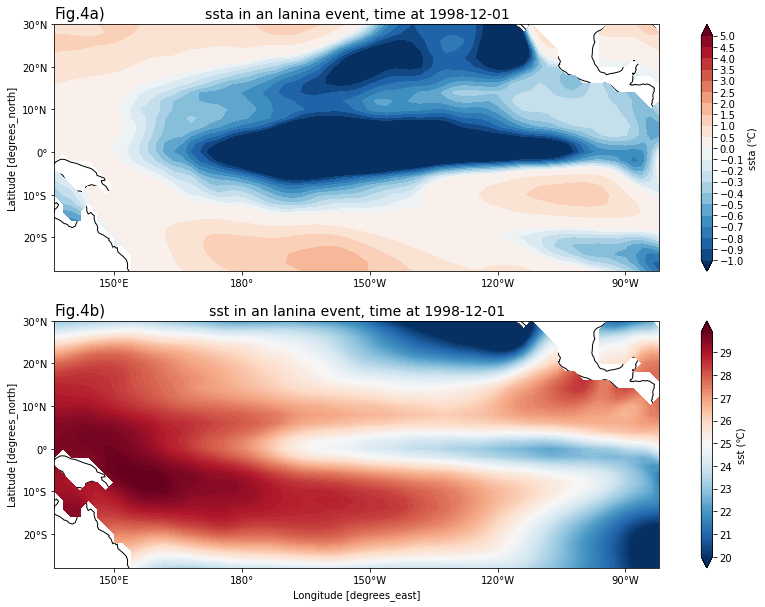

In [377]:
showt = datetime.datetime(1998,12,1)
##拼接level
fig=plt.figure(figsize=[15,10])

ax= fig.add_subplot(2,1,1,projection=ccrs.PlateCarree(central_longitude=180))

# clevs = np.arange(-1,4,0.5)
proj = ccrs.PlateCarree(central_longitude=180)

leftlon, rightlon, lowerlat, upperlat = (0,360,-90,90)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
ax.set_xticks(np.arange(leftlon,rightlon+30,30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
lev1,lev2 = np.arange(-1,0,0.1),np.arange(0,5+0.5,0.5)
clevs=np.append(lev1,lev2)
cbar_kwargs = {
   'orientation': 'vertical',
   'label': 'ssta (℃)',
   'shrink': 1,
    'ticks': clevs   
}
ssta.sel(time=showt).plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,extend='both',
                             cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree())#,cbar_ax=fig.add_axes([0.13, 0.06, 0.35, 0.03]))
ax.set_title('ssta in an lanina event, time at '+str(showt)[:10],fontsize=14)
ax.set_title('Fig.4a)',loc='left',fontsize=15)
ax.set_xlabel('')
i=1
ax = fig.add_subplot(212,projection=ccrs.PlateCarree(central_longitude=180))

# clevs = np.arange(-1,4,0.5)
proj = ccrs.PlateCarree(central_longitude=180)

leftlon, rightlon, lowerlat, upperlat = (0,360,-90,90)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
ax.set_xticks(np.arange(leftlon,rightlon+30,30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
lev1,lev2 = np.arange(-1,0,0.1),np.arange(0,5+0.5,0.5)
clevs=np.arange(20,30,0.1)
cbar_kwargs = {
   'orientation': 'vertical',
   'label': 'sst (℃)',
   'shrink': 1,
    'ticks': np.arange(20,30+1,1) 
}

sst.sel(time=showt).plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,extend='both',
                             cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree())#,cbar_ax=fig.add_axes([0.55, 0.06, 0.35, 0.03]))
ax.set_title('sst in an lanina event, time at '+str(showt)[:10],fontsize=14)
ax.set_title('Fig.4b)',loc='left',fontsize=15)

plt.savefig('fig4.jpg',bbox_inches = 'tight',dpi=300)

方差

In [204]:
variance = ssta.var(dim='time')

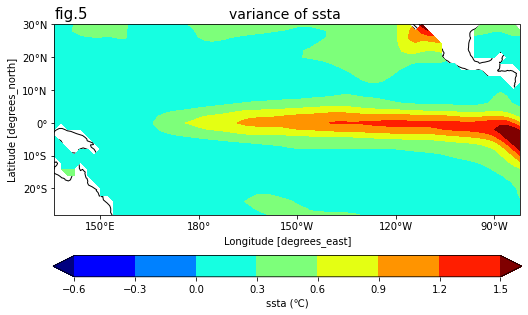

In [221]:
plt.figure(figsize=[10,5])
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
# lev1,lev2 = np.arange(-3,0,0.3),np.arange(0,1+0.1,0.1)
# clevs=np.append(lev1,lev2)
clevs = np.arange(-0.6,1.8,0.3)
proj = ccrs.PlateCarree(central_longitude=180)

leftlon, rightlon, lowerlat, upperlat = (0,360,-90,90)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
ax.set_xticks(np.arange(leftlon,rightlon+30,30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

cbar_kwargs = {
   'orientation': 'horizontal',
   'label': 'ssta (℃)',
   'shrink': 0.84,
    'ticks': clevs#np.arange(-1,1+0.1,0.1)    
}

variance.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.jet,extend='both',
                             cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree())

# ax.set_title('ssta, time='+str(showt)[:10],fontsize=15)
ax.set_title('variance of ssta ',fontsize=14)

ax.set_title('fig.5',loc='left',fontsize=15)
plt.savefig('fig5.jpg',bbox_inches = 'tight',dpi=300)

skweness

In [215]:
import pandas as pd
ssta_skew = ssta[0,:,:].copy()
for j in np.arange(sst.shape[1]):
    for k in np.arange(sst.shape[2]):
        ssta_pd = ssta[:,j,k].to_pandas()
        ssta_skew[j,k]=ssta_pd.skew()

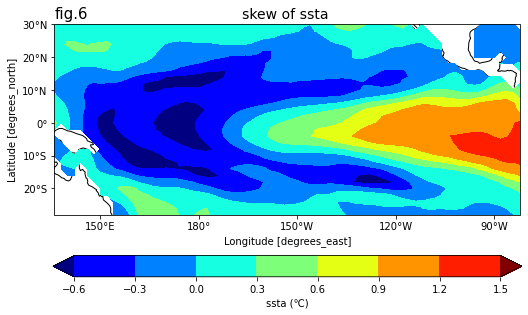

In [220]:
plt.figure(figsize=[10,5])
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
# lev1,lev2 = np.arange(-3,0,0.3),np.arange(0,1+0.1,0.1)
# clevs=np.append(lev1,lev2)
clevs = np.arange(-0.6,1.8,0.3)
proj = ccrs.PlateCarree(central_longitude=180)

leftlon, rightlon, lowerlat, upperlat = (0,360,-90,90)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
ax.set_xticks(np.arange(leftlon,rightlon+30,30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat+10,10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

cbar_kwargs = {
   'orientation': 'horizontal',
   'label': 'ssta (℃)',
   'shrink': 0.84,
    'ticks': clevs#np.arange(-1,1+0.1,0.1)    
}

ssta_skew.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.jet,extend='both',
                             cbar_kwargs=cbar_kwargs, transform=ccrs.PlateCarree())

# ax.set_title('ssta, time='+str(showt)[:10],fontsize=15)
ax.set_title('skew of ssta ',fontsize=14)

ax.set_title('fig.6',loc='left',fontsize=15)
plt.savefig('fig6.jpg',bbox_inches = 'tight',dpi=300)